In [1]:
#Data manipulation libraries
%matplotlib inline
import pandas as pd
from pandas import DataFrame, Series
from datetime import datetime, timedelta
import numpy as np
import seaborn as sns

#Plotting packages
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn
from seaborn import heatmap

#Machine learning and stats libraries
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, auc
from scipy import stats

In [2]:
total_features=pd.read_csv('all_features_v1.csv');

In [41]:
total_features.columns

Index([u'msno', u'count', u'pay_method_unique', u'pay_method_sum',
       u'pay_method_mean', u'pay_method_std', u'pay_method_min',
       u'pay_method_max', u'pay_method_last', u'pay_days_unique',
       u'pay_days_sum', u'pay_days_mean', u'pay_days_std', u'pay_days_min',
       u'pay_days_max', u'pay_days_last', u'price_unique', u'price_sum',
       u'price_mean', u'price_std', u'price_min', u'price_max', u'price_last',
       u'paid_unique', u'paid_sum', u'paid_mean', u'paid_std', u'paid_min',
       u'paid_max', u'paid_last', u'auto_renew_unique', u'auto_renew_sum',
       u'auto_renew_mean', u'auto_renew_std', u'auto_renew_min',
       u'auto_renew_max', u'auto_renew_last', u'cancel_unique', u'cancel_sum',
       u'cancel_mean', u'cancel_std', u'cancel_min', u'cancel_max',
       u'cancel_last', u'discount_unique', u'discount_sum', u'discount_mean',
       u'discount_std', u'discount_min', u'discount_max', u'discount_last',
       u'transaction_time_total', u'activity', u'last_num

In [46]:
num_retained=len(total_features[total_features['is_churn']==0]['msno'])
num_churned=len(total_features[total_features['is_churn']==1]['msno'])
num_total=num_retained+num_churned
prob_ret=1.0*num_retained/num_total
prob_churn=1.0*num_churned/num_total

In [87]:
num_retained_no_AR=len(total_features[total_features['is_churn']==0][total_features['cancel_last']==0]['msno'])
num_retained_AR=len(total_features[total_features['is_churn']==0][total_features['cancel_last']==1]['msno'])
num_churned_no_AR=len(total_features[total_features['is_churn']==1][total_features['cancel_last']==0]['msno'])
num_churned_AR=len(total_features[total_features['is_churn']==1][total_features['cancel_last']==1]['msno'])
num_tot_no_AR=num_retained_no_AR+num_churned_no_AR
num_tot_AR=num_retained_AR+num_churned_AR

ratio=(1.0*num_retained_AR/num_tot_AR)/prob_ret

print ratio

/opt/conda/lib/python2.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


0.278989452628


/opt/conda/lib/python2.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/opt/conda/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python2.7/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


# KKBox music streaming service churn prediction

* Utilize KKBox Music Prediction Challenge Dataset available at https://www.kaggle.com/c/kkbox-churn-prediction-challenge/data.


## Problem statement
    
* Can user demographics, transactions log data be utilized to predict whether a user will churn in a given month?

* __Churn:__ Fail to renew subscription within 30 days after current subscription expiration.


## Motivation

* Many products and services are now provided with a subscrition based distribution. 
* This drives an industry need: Utilization of user behavior to understand and predict user retention.
    * Could be used for example to do targeted advertising or revenue prediction
    
# Stories from the data

## Population imbalance: 
* Roughly 14:1 ratio of retained to churn users

$
\qquad P(is\_churn) \approx \left\{
        \begin{array}{ll}
            0.93 & \quad is\_churn = False \quad (retained)  \\
            0.07 & \quad is\_churn = True \quad (churned)
        \end{array}
    \right.
$

## Churn users are on average younger:

The t-test for difference in mean age between churn and retained users gives:
Ttest_indResult(statistic=-53.40219993088887, pvalue=0.0)


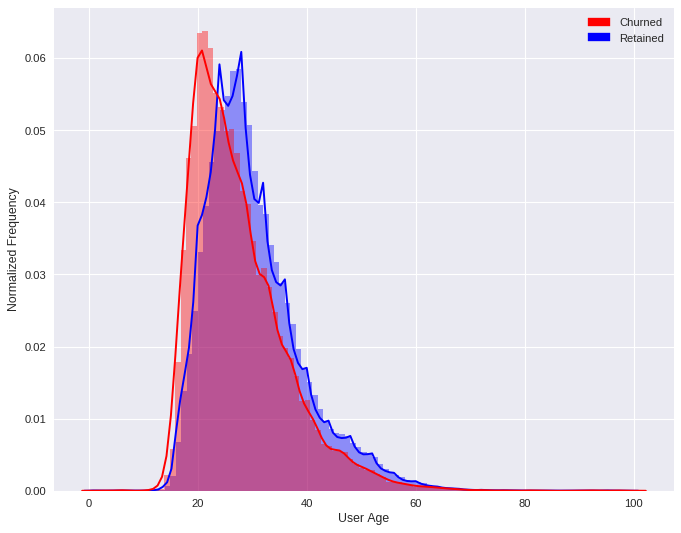

In [61]:
usezchurn=total_features[total_features['is_churn']==0]
useochurn=total_features[total_features['is_churn']==1]
usezbadrm=usezchurn[usezchurn['bd']>0]
usezbadrm=usezbadrm[usezbadrm['bd']<100]
useobadrm=useochurn[useochurn['bd']>0]
useobadrm=useobadrm[useobadrm['bd']<100]

print("The t-test for difference in mean age between churn and retained users gives:")
print(stats.ttest_ind(useobadrm['bd'], usezbadrm['bd'], axis=0, equal_var=False))

bins = np.linspace(1, 100, 100)
plt.figure(figsize=(10, 8), dpi= 80, facecolor='w', edgecolor='k')
sns.distplot(usezbadrm['bd'],bins=98,color='blue')
sns.distplot(useobadrm['bd'],bins=98,color='red')
plt.xlabel('User Age')
plt.ylabel('Normalized Frequency')
red_patch = mpatches.Patch(color='red', label='Churned')
blue_patch = mpatches.Patch(color='blue', label='Retained')
plt.legend(handles=[red_patch,blue_patch])
plt.show()

## Churn users don't tend to use auto renew

## $P(is\_churn \phantom{..} $|$ \phantom{..}auto\_renew\_ever\_used)/P(is\_churn)$

|  No Auto Renew|   Auto Renew |
 ------|------|------|
__Retained__      |0.72|1.03|
__Churned__      | 4.93 | 0.44 |


## Churn users don't tend to use auto renew

## $P(is\_churn \phantom{..} $|$ \phantom{..}last\_transaction\_is\_cancel)/P(is\_churn)$

|  Cancelled |   Not Cancelled  |
 ------|------|------|
__Retained__      |0.28|1.02|
__Churned__      | 11.23 | 0.67 |

In [96]:
total_features=total_features.replace({'male':0.0,'female':1.0})
total_features=total_features.fillna(-1.0)
total_features[(total_features['bd']<0)] =0
total_features[(total_features['bd']>100)]=0 

#Split into a training and testing set by sampling without replacement
trainrows = np.random.rand(len(total_features['msno'])) < 0.80
train = total_features[trainrows]
test = total_features[~trainrows]
Xtrain=train.drop(['msno','is_churn'],axis=1)
Ytrain=train['is_churn']

#Make a validation set
mskval = np.random.rand(len(train)) < 0.70
trainval=train[mskval]
validation=train[~mskval]

best_log_loss_LR=1000
best_log_loss_RF=100

uloglossLRall=[]

uloglossRFall=[]

In [97]:
for m in [1,5,9,14]:
    usezchurn=trainval[trainval['is_churn']==0]
    useochurn=trainval[trainval['is_churn']==1]
    usezchurnusamp=usezchurn.sample(n=m*int(useochurn.shape[0]),replace=False)

    trainusamp=usezchurnusamp.append(useochurn)
    Xusamptrain=trainusamp.drop(['msno','is_churn'],axis=1)
    yusamptrain=(trainusamp['is_churn'])
    Xusampval=validation.drop(['msno','is_churn'],axis=1)
    yusampval=(validation['is_churn'])
    
    #Create a logistic regression model
    umodelLR=LogisticRegression()
    umodelLR.fit(Xusamptrain,yusamptrain)
    upredsLR = umodelLR.predict_proba(Xusampval)[:,1]
    ufprLR, utprLR, _LR = metrics.roc_curve(yusampval, upredsLR)

    udfLR = pd.DataFrame(dict(fpr=ufprLR, tpr=utprLR))

    #Create a random forest model
    uRFmodel=RandomForestClassifier(n_estimators=150,random_state=0,n_jobs=-1)
    uRFmodel.fit(Xusamptrain,yusamptrain)
    uRFpreds = uRFmodel.predict_proba(Xusampval)[:,1]
    uRFfpr, uRFtpr, _ = metrics.roc_curve(yusampval, uRFpreds)
    udfRF = pd.DataFrame(dict(fpr=uRFfpr, tpr=uRFtpr))
    
    uyLRpred=umodelLR.predict(Xusampval)

    uyRFpred=uRFmodel.predict(Xusampval)

    uloglossLR=metrics.log_loss(yusampval,uyLRpred)
    uloglossRF=metrics.log_loss(yusampval,uyRFpred)
    
    uloglossLRall.append(uloglossLR)
    uloglossRFall.append(uloglossRF)
    
    
    if uloglossLR<best_log_loss_LR:
        
        best_log_loss_LR=best_log_loss_LR
        best_LR_model=umodelLR
        LRsamprat=m
    
    if uloglossRF<best_log_loss_RF:
        
        best_log_loss_RF=uloglossRF
        best_RF_model=uRFmodel
        RFsamprat=m
        


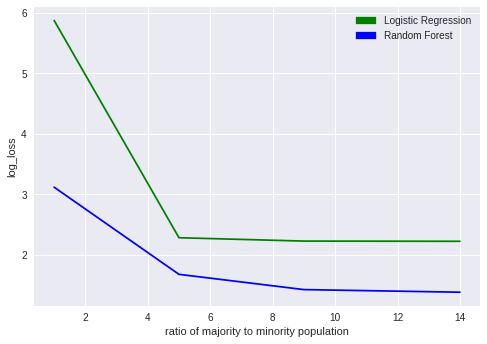

In [113]:
green_patch = mpatches.Patch(color='green', label='Logistic Regression')
blue_patch = mpatches.Patch(color='blue', label='Random Forest')

plt.plot([1,5,9,14,14],uloglossLRall,c='g')
plt.plot([1,5,9,14,14],uloglossRFall,c='b')
plt.xlabel('ratio of majority to minority population')
plt.ylabel('log_loss')
plt.legend(handles=[green_patch,blue_patch],loc='upper right')
plt.show()

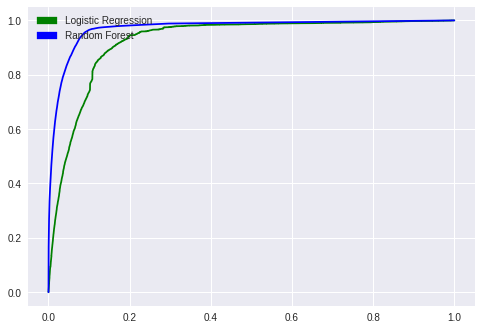

('Area under curve for Logistic Regression:', 0.92574569196173806)
('Log-loss for Logistic Regression:', 2.2225443806495973)
('Area under curve for Random Forest:', 0.97157370094843198)
('Log-loss for Random Forest:', 1.3799373955339542)


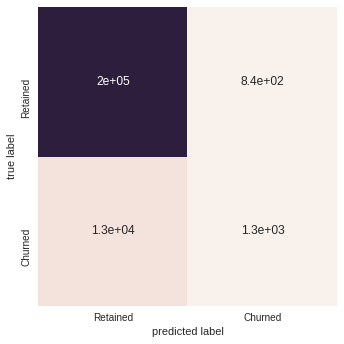

('Sensitivity is:', 0.09307978267086074)
('Specificity is:', 0.9957188508172408)
('Positive Predictive Value is:', 0.6078431372549019)
('Negative Predictive Value is:', 0.9390257383864843)
('Accuracy is:', 0.9356508418293316)


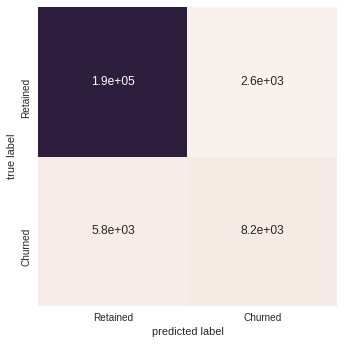

('Sensitivity is:', 0.5835001429796969)
('Specificity is:', 0.9868915289308849)
('Positive Predictive Value is:', 0.7603875535681014)
('Negative Predictive Value is:', 0.970791575379895)
('Accuracy is:', 0.9600470035252644)


In [99]:
#Create a logistic regression model
umodelLR=best_LR_model
umodelLR.fit(Xusamptrain,yusamptrain)
upredsLR = umodelLR.predict_proba(Xusampval)[:,1]
ufprLR, utprLR, _LR = metrics.roc_curve(yusampval, upredsLR)

udfLR = pd.DataFrame(dict(fpr=ufprLR, tpr=utprLR))

#Create a random forest model
uRFmodel=best_RF_model
uRFmodel.fit(Xusamptrain,yusamptrain)
uRFpreds = uRFmodel.predict_proba(Xusampval)[:,1]
uRFfpr, uRFtpr, _ = metrics.roc_curve(yusampval, uRFpreds)
udfRF = pd.DataFrame(dict(fpr=uRFfpr, tpr=uRFtpr))

uyLRpred=umodelLR.predict(Xusampval)

uyRFpred=uRFmodel.predict(Xusampval)

uloglossLR=metrics.log_loss(yusampval,uyLRpred)
uloglossRF=metrics.log_loss(yusampval,uyRFpred)

uloglossLRall.append(uloglossLR)
uloglossRFall.append(uloglossRF)
## Define a few metrics
def Sensitivity(confmat):
    val=1.0*confmat[1,1]/(confmat[1,1]+confmat[1,0])
    return val

def Specificity(confmat):
    val=1.0*confmat[0,0]/(confmat[0,0]+confmat[0,1])
    return val
    
def PPV(confmat):
    val=1.0*confmat[1,1]/(confmat[1,1]+confmat[0,1])
    return val

def NPV(confmat):
    val=1.0*confmat[0,0]/(confmat[1,0]+confmat[0,0])  
    return val

def Accuracy(confmat):
    val=1.0*(confmat[0,0]+confmat[1,1])/(confmat[0,0]+confmat[1,1]+confmat[1,0]+confmat[0,1])  
    return val
    
#Plot the ROC for each
plt.plot(udfLR['fpr'],udfLR['tpr'],color='green');
plt.plot(udfRF['fpr'],udfRF['tpr'],color='blue');
green_patch = mpatches.Patch(color='green', label='Logistic Regression')
blue_patch = mpatches.Patch(color='blue', label='Random Forest')
plt.legend(handles=[green_patch,blue_patch],loc='upper left')
plt.show()

#Take a look at the confusion matrix and calculate a few statistics
Xtest=test.drop(['msno','is_churn'],axis=1)
Ytest=test['is_churn']

uyLRpred=umodelLR.predict(Xusampval)

uyRFpred=uRFmodel.predict(Xusampval)




uaucLR = metrics.auc(ufprLR,utprLR)
uloglossLR=metrics.log_loss(yusampval,uyLRpred)
uaucRF = metrics.auc(uRFfpr,uRFtpr)
uloglossRF=metrics.log_loss(yusampval,uyRFpred)

print("Area under curve for Logistic Regression:", uaucLR)
print("Log-loss for Logistic Regression:",uloglossLR)
print("Area under curve for Random Forest:", uaucRF)
print("Log-loss for Random Forest:",uloglossRF)

umatLR=confusion_matrix(yusampval,uyLRpred)
seaborn.heatmap(umatLR,square=True,annot=True,cbar=False,xticklabels=['Retained','Churned'],yticklabels=['Retained','Churned'])
plt.xlabel('predicted label')
plt.ylabel('true label')
plt.show()


print("Sensitivity is:",Sensitivity(umatLR))

print("Specificity is:",Specificity(umatLR))

print("Positive Predictive Value is:",PPV(umatLR))

print("Negative Predictive Value is:",NPV(umatLR))

print("Accuracy is:",Accuracy(umatLR))



umatRF=confusion_matrix(yusampval,uyRFpred)
seaborn.heatmap(umatRF,square=True,annot=True,cbar=False,xticklabels=['Retained','Churned'],yticklabels=['Retained','Churned'])
plt.xlabel('predicted label')
plt.ylabel('true label')
plt.show()                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        

print("Sensitivity is:",Sensitivity(umatRF))

print("Specificity is:",Specificity(umatRF))

print("Positive Predictive Value is:",PPV(umatRF))

print ("Negative Predictive Value is:",NPV(umatRF))

print ("Accuracy is:",Accuracy(umatRF))